In [7]:
###############
# Import the data
###############

import pandas as pd

building_metadata = pd.read_csv('data/building_metadata.csv', dtype={'building_id': 'int16', 'primary_use': 'category'})
building_meter_readings = pd.read_csv('data/building_meter_readings.csv', parse_dates=['timestamp'], dtype={'meter': 'int16', 'meter_reading': 'float64', 'building_id': 'int16'})
weather_data = pd.read_csv('data/weather_data.csv', parse_dates=['timestamp'])

# Join all data
data = pd.merge(building_meter_readings, building_metadata, on='building_id')
data = pd.merge(data, weather_data, on=['site_id', 'timestamp'])

20125605
   building_id  meter  timestamp  meter_reading  site_id primary_use  \
0            0      0 2016-01-01            0.0        0   Education   
1            1      0 2016-01-01            0.0        0   Education   
2            2      0 2016-01-01            0.0        0   Education   
3            3      0 2016-01-01            0.0        0   Education   
4            4      0 2016-01-01            0.0        0   Education   

   square_feet  year_built  floor_count  air_temperature  cloud_coverage  \
0         7432      2008.0          NaN             25.0             6.0   
1         2720      2004.0          NaN             25.0             6.0   
2         5376      1991.0          NaN             25.0             6.0   
3        23685      2002.0          NaN             25.0             6.0   
4       116607      1975.0          NaN             25.0             6.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0      

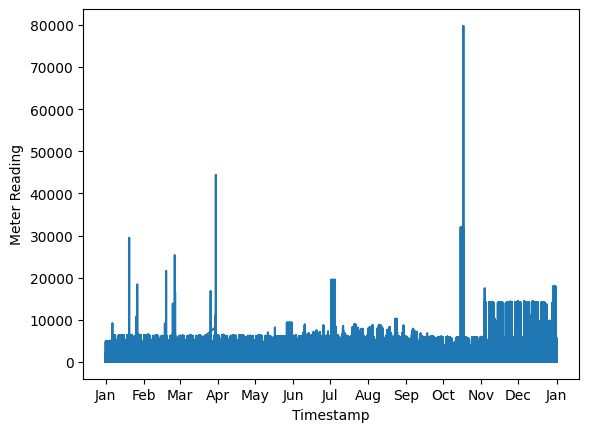

In [8]:
###############
# Data Exploration
###############
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

print(len(data))

print(data.head())

print(data['primary_use'].value_counts())
# plt.close()

# plot meter readings for building 0
building_0 = data[data['building_id'] == 0]
# plot only meter 0
building_0 = data[data['meter'] == 0]

xpoints = building_0['timestamp']
ypoints = building_0['meter_reading']


plt.plot(xpoints, ypoints)
plt.xlabel("Timestamp")
plt.ylabel("Meter Reading")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.show()



In [9]:
###############
# Data cleaning
###############

print("Rows before cleaning: " + str(len(data)))

# remove meter_reading 0 values
print("Removed " + str(len(data[data['meter_reading'] == 0])) + " rows with meter_reading = 0")
data = data[data['meter_reading'] != 0]

# remove rows with missing values
print("Removed " + str(data.isna().any(axis=1).sum()) + " rows with missing values")
data.dropna(inplace=True)

# Only keep electricity meter readings
print("Removed " + str(len(data['meter'] != 0)) + " rows with non-electricity meter readings")
data = data[data['meter'] == 0]
print("Rows remaining: " + str(len(data)))

#Convert timestamp into hour of day, day of week and month
data['hour'] = data['timestamp'].dt.hour
data['day'] = data['timestamp'].dt.dayofweek
data['month'] = data['timestamp'].dt.month
data.drop('timestamp', axis=1, inplace=True)

# encode categorical variables (one-hot encoding)
data = pd.get_dummies(data, columns=['primary_use'])

data = data.sample(n=10000, random_state=42)

Rows before cleaning: 20125605
Removed 1867887 rows with meter_reading = 0
Removed 17937883 rows with missing values
Removed 319835 rows with non-electricity meter readings
Rows remaining: 319835


Mean Squared Error test: 1186.8036960660243
Mean Squared Error train: 157.3136863789729


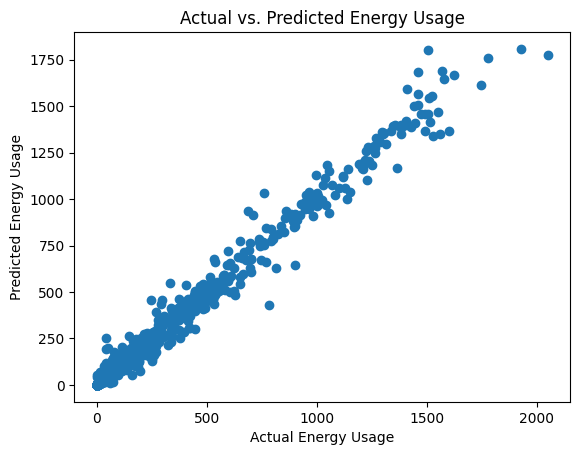

Random Forest results: (157.3136863789729, 1186.8036960660243)


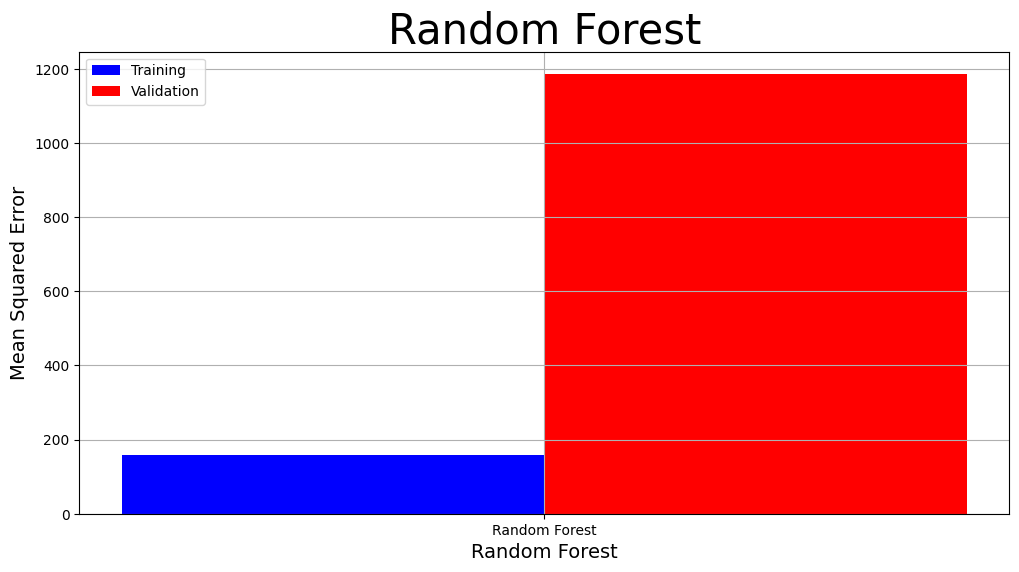

Mean Squared Error test: 39797.8140034897
Mean Squared Error train: 38024.05660667981


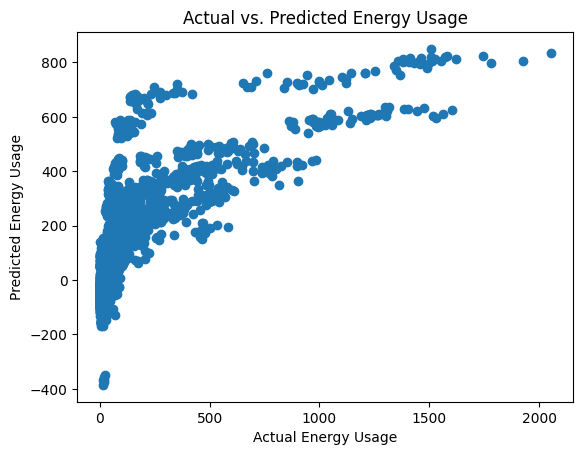

Linear Regression results: (38024.05660667981, 39797.8140034897)


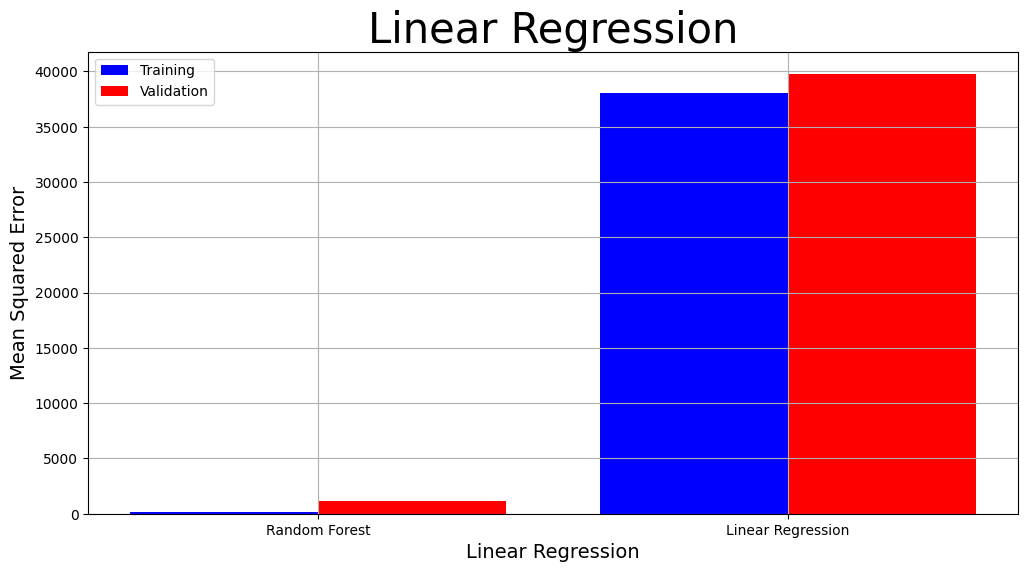

Mean Squared Error test: 2445.0773369989975
Mean Squared Error train: 2115.0380165119614


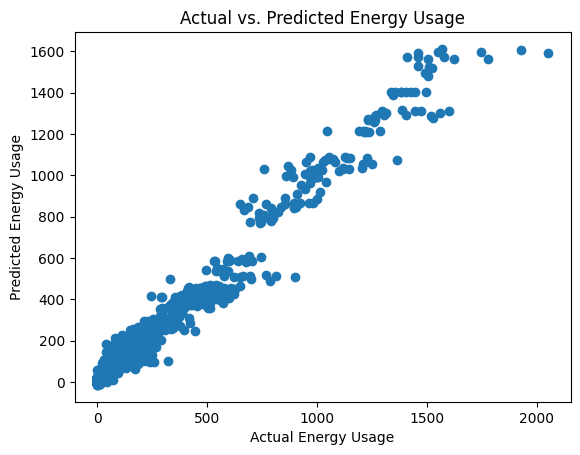

Gradient Boosting results: (2115.0380165119614, 2445.0773369989975)


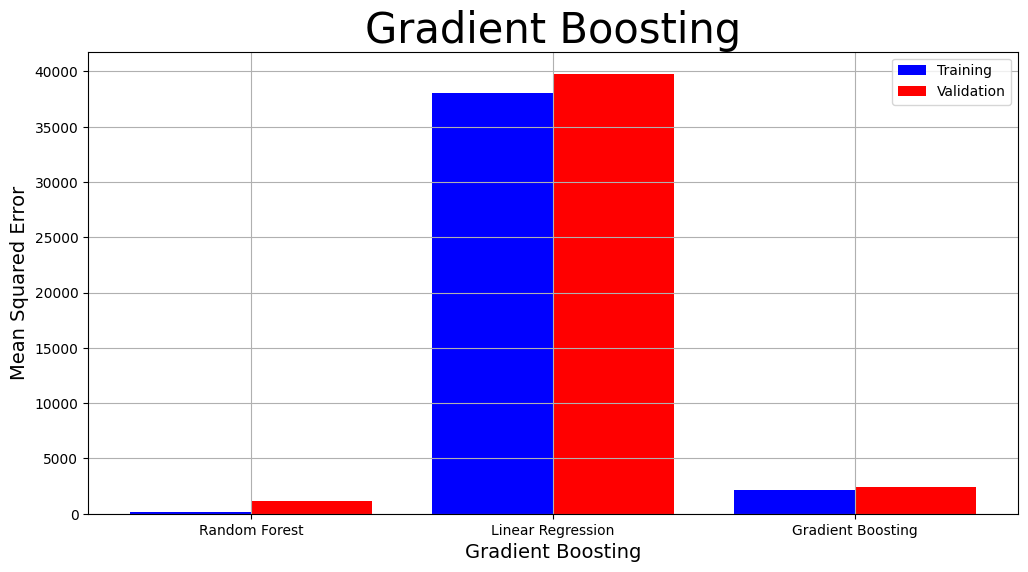

Mean Squared Error test: 72928.99149517482
Mean Squared Error train: 69308.94171950093


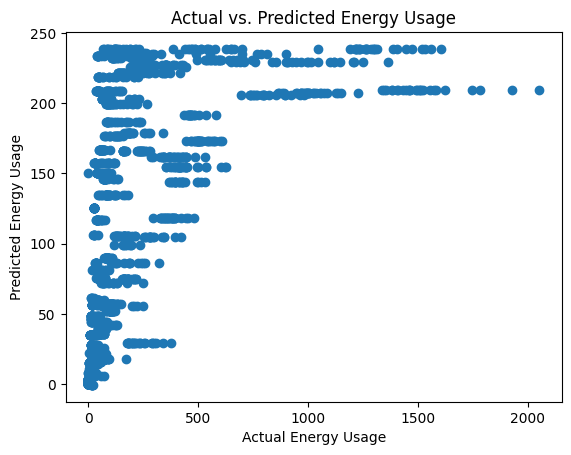

SVR results: (69308.94171950093, 72928.99149517482)


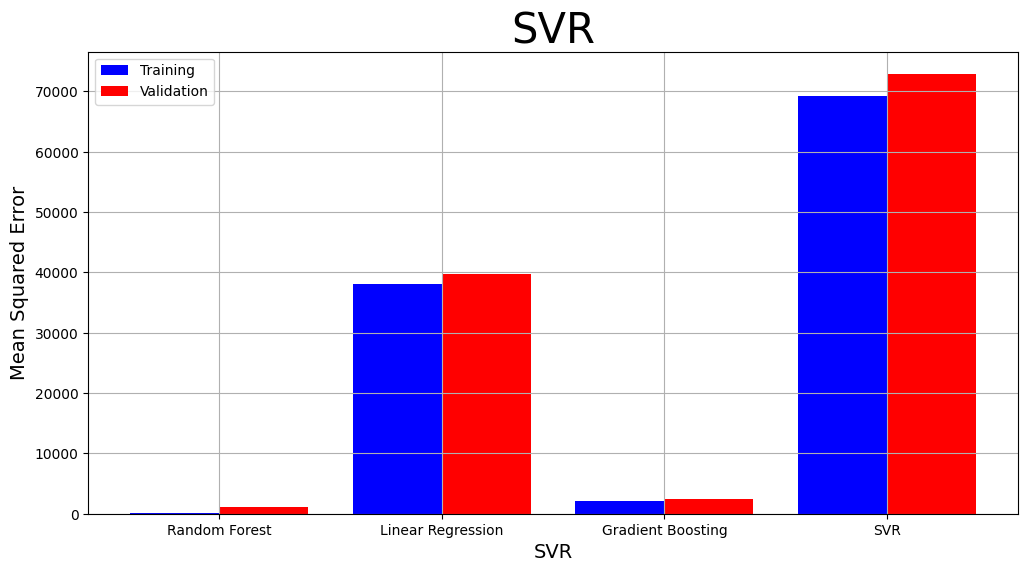

In [29]:
import numpy as np
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

def run_model(model, k_fold=0):
    y = data['meter_reading']
    x = data.drop(columns=['meter_reading'], inplace=False)

    if k_fold == 0:

        # Split the dataset into training and testing sets
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

        # Train the model
        model.fit(x_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(x_test)

        # Make predictions on the training set
        y_pred_train = model.predict(x_train)

        # Evaluate the model
        mse_test = mean_squared_error(y_test, y_pred)
        mse_train = mean_squared_error(y_train, y_pred_train)
        print(f'Mean Squared Error test: {mse_test}')
        print(f'Mean Squared Error train: {mse_train}')

        # Plot actual vs. predicted values
        plt.scatter(y_test, y_pred)
        plt.xlabel('Actual Energy Usage')
        plt.ylabel('Predicted Energy Usage')
        plt.title('Actual vs. Predicted Energy Usage')
        plt.show()

        return mse_train, mse_test
    else:
        return cross_validate(model, x, y, cv=5, return_train_score=True, scoring='neg_mean_squared_error')



# Grouped Bar Chart for both training and validation data
def plot_results(x_label, y_label, plot_title, results):
    '''Function to plot a grouped bar chart showing the training and validation
      results of the ML model in each fold after applying K-fold cross-validation.
     Parameters
     ----------
     x_label: str,
        Name of the algorithm used for training e.g 'Decision Tree'

     y_label: str,
        Name of metric being visualized e.g 'Accuracy'
     plot_title: str,
        This is the title of the plot e.g 'Accuracy Plot'

     train_result: list, array
        This is the list containing either training precision, accuracy, or f1 score.

     val_result: list, array
        This is the list containing either validation precision, accuracy, or f1 score.
     Returns
     -------
     The function returns a Grouped Barchart showing the training and validation result
     in each fold.
    '''

    # Set size of plot
    plt.figure(figsize=(12,6))
    labels = [result["name"] for result in results]
    X_axis = np.arange(len(labels))
    ax = plt.gca()

    plt.bar(X_axis-0.2, list(map(lambda x: x['train_mse'], results)) , 0.4, color='blue', label='Training')
    plt.bar(X_axis+0.2, list(map(lambda x: x['test_mse'], results)), 0.4, color='red', label='Validation')
    plt.title(plot_title, fontsize=30)
    plt.xticks(X_axis, labels)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()


settings = [('Random Forest', RandomForestRegressor()), ('Linear Regression', LinearRegression()), ('Gradient Boosting', GradientBoostingRegressor()), ('SVR', SVR())]
results = []
for (name, model) in settings:
    result = run_model(model)
    print(name + " results: " + str(result))
    results.append({'name': name, 'train_mse': result[0], 'test_mse': result[1]})
    plot_results(name, "Mean Squared Error", name, results)

